In [ ]:
#Install required packages

!pip -qq install epam.indigo

!pip install rdkit-pypi
!pip install pubchempy
!pip install rxn4chemistry
!pip install rxnmapper

In [35]:
from indigo import Indigo
indigo = Indigo()

from indigo.inchi import IndigoInchi
inchi = IndigoInchi(indigo)

from indigo.renderer import IndigoRenderer
renderer = IndigoRenderer(indigo)

from rxnmapper import RXNMapper

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from IPython.display import SVG, display, Image
import io
import re

import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np

## RXNMapper

In [56]:
brenda = pd.read_csv('brenda_smiles.csv')
valid = brenda[['substrates_converted_smiles','products_converted_smiles']]

valid = valid.drop_duplicates()
valid['substrates_converted_smiles'] = valid['substrates_converted_smiles'].apply(ast.literal_eval)
valid['products_converted_smiles'] = valid['products_converted_smiles'].apply(ast.literal_eval)

# Remove common cofactors
for index,row in valid.iterrows():
    substrate = row['substrates_converted_smiles']
    pdt = row['products_converted_smiles']
    
    nad_plus = 'C1=CC(=C[N+](=C1)[C@H]2[C@@H]([C@@H]([C@H](O2)COP(=O)([O-])OP(=O)(O)OC[C@@H]3[C@H]([C@H]([C@@H](O3)N4C=NC5=C(N=CN=C54)N)O)O)O)O)C(=O)N'
    nadh = 'C1C=CN(C=C1C(=O)N)[C@H]2[C@@H]([C@@H]([C@H](O2)COP(=O)(O)OP(=O)(O)OC[C@@H]3[C@H]([C@H]([C@@H](O3)N4C=NC5=C(N=CN=C54)N)O)O)O)O'
    nadp_plus = 'C1=CC(=C[N+](=C1)[C@H]2[C@@H]([C@@H]([C@H](O2)COP(=O)(O)OP(=O)(O)OC[C@@H]3[C@H]([C@H]([C@@H](O3)N4C=NC5=C(N=CN=C54)N)OP(=O)(O)O)O)O)O)C(=O)N'
    nadph = 'C1C=CN(C=C1C(=O)N)[C@H]2[C@@H]([C@@H]([C@H](O2)COP(=O)(O)OP(=O)(O)OC[C@@H]3[C@H]([C@H]([C@@H](O3)N4C=NC5=C(N=CN=C54)N)OP(=O)(O)O)O)O)O'
    hydrogen = '[H+]'

    cofactors = [nad_plus, nadh, nadp_plus, nadph, hydrogen]

    for i in cofactors:
        if i in substrate:
            substrate.remove(i)
        if i in pdt:
            pdt.remove(i)

    if len(substrate) == 0 or len(pdt) == 0:
        continue
    
valid = valid[valid['substrates_converted_smiles'].astype(bool) & valid['products_converted_smiles'].astype(bool)]

In [57]:
rxn_mapper = RXNMapper()

def rxnmapper_map_reaction(reactants_smiles, products_smiles):
    reactants_str = '.'.join(reactants_smiles)
    products_str = '.'.join(products_smiles)

    reaction_smiles = f"{reactants_str}>>{products_str}"

    mapped_reaction = rxn_mapper.get_attention_guided_atom_maps([reaction_smiles])

    return mapped_reaction[0]['mapped_rxn']

def draw_chemical_reaction(smiles, highlightByReactant=False, font_scale=0.8):
    rxn = rdChemReactions.ReactionFromSmarts(smiles,useSmiles=True)
    trxn = rdChemReactions.ChemicalReaction(rxn)
    for m in trxn.GetReactants():
        moveAtomMapsToNotes(m)
    for m in trxn.GetProducts():
        moveAtomMapsToNotes(m)
    d2d = rdMolDraw2D.MolDraw2DSVG(900,300)
    d2d.drawOptions().annotationFontScale=font_scale
    d2d.DrawReaction(trxn,highlightByReactant=highlightByReactant)

    d2d.FinishDrawing()

    return d2d.GetDrawingText()

def moveAtomMapsToNotes(m):
    for at in m.GetAtoms():
        if at.GetAtomMapNum():
            at.SetProp("atomNote",str(at.GetAtomMapNum()))
            
def add_rxnmapper_mapping(df):
    mapped_rxn_smiles = []
    for i in range(df.shape[0]):
       mapped_rxn_smiles.append(rxnmapper_map_reaction(df['substrates_converted_smiles'].iloc[i], df['products_converted_smiles'].iloc[i]))
    df["rxnmapper_mapped_smiles"] = mapped_rxn_smiles
    
add_rxnmapper_mapping(valid)

## Generate synthetic invalid reactions — Grouping by Carbon 

In [ ]:
invalid = valid.copy(deep=True)

def find_Cs(row):
    return [len(re.findall(r'C', i)) for i in row][0]

invalid["substrate_Cs"] = invalid["substrates_converted_smiles"].apply(find_Cs)
invalid["products_Cs"] = invalid["products_converted_smiles"].apply(find_Cs)

new_invalid = pd.DataFrame({})
numC = np.sort(invalid["substrate_Cs"].unique())
for num in numC:
    indiv = invalid[invalid["substrate_Cs"] == num].copy()
    indiv['permuted_products_smiles'] = np.roll(indiv['products_converted_smiles'], 1)
    new_invalid = pd.concat([new_invalid, indiv], axis=0)
    
invalid_rxnmapper_mapped_rxn_smiles = []
for i in range(new_invalid.shape[0]):
    invalid_rxnmapper_mapped_rxn_smiles.append(rxnmapper_map_reaction(new_invalid['permuted_products_smiles'].iloc[i], new_invalid['products_converted_smiles'].iloc[i]))
new_invalid["rxnmapper_mapped_smiles"] = invalid_rxnmapper_mapped_rxn_smiles
new_invalid.drop(['products_converted_smiles'], axis=1, inplace=True)
new_invalid.rename({'permuted_products_smiles': 'products_converted_smiles'}, axis=1, inplace=True)

In [62]:
valid.to_csv("valid_maps.csv")
new_invalid.to_csv("invalid_maps.csv")

## Generate atom mapping metrics

In [ ]:
def carbonMetrics(mapped_reaction_smiles):
    if(mapped_reaction_smiles == ">>"):
        return(-1,-1,-1,-1,-1,-1,-1,-1,-1,-1)
    
    # Pull reactions from smiles
    rdkit_reaction = AllChem.ReactionFromSmarts(mapped_reaction_smiles, useSmiles=True)

    reactant_labels = {}
    product_labels = {}

    for mol in rdkit_reaction.GetReactants():
        AllChem.Compute2DCoords(mol)

    for mol in rdkit_reaction.GetProducts():
        AllChem.Compute2DCoords(mol)

    for reactant in rdkit_reaction.GetReactants():
        for atomR in reactant.GetAtoms():
            label = f'{atomR.GetSymbol()}{atomR.GetAtomMapNum()}'
            reactant_labels[label] = atomR.GetSymbol()

    for product in rdkit_reaction.GetProducts():
        for atom in product.GetAtoms():
            label = f'{atom.GetSymbol()}{atom.GetAtomMapNum()}'
            product_labels[label] = atom.GetSymbol()

    # Total number of carbon atoms, proportion of carbon atoms gained or lost
    rdkit_reaction = AllChem.ReactionFromSmarts(mapped_reaction_smiles, useSmiles=True)
    CarbonR, CarbonP = 0,0
    CarbonsGained, CarbonsLost = 0,0

    # Count carbons in reactants
    for reactant in rdkit_reaction.GetReactants():
      for atomR in reactant.GetAtoms():
         if atomR.GetSymbol() == 'C':
          CarbonR += 1

    # Count carbons in products
    for product in rdkit_reaction.GetProducts():
      for atomP in product.GetAtoms():
         if atomP.GetSymbol() == 'C':
          CarbonP += 1

    # Count if carbons have been lost or gained
    if CarbonP > CarbonR:
      CarbonsGained = CarbonP-CarbonR
    elif CarbonR > CarbonP:
      CarbonsLost = CarbonR-CarbonP
    else:
      CarbonsGained = 0
      CarbonsLost = 0

    TotalCarbons = CarbonP + CarbonR
    if TotalCarbons == 0:
      TotalCarbons = -1
    propCarbonsGained = CarbonsGained/TotalCarbons
    propCarbonsLost = CarbonsLost/TotalCarbons
    CarbonMetrics = [TotalCarbons,propCarbonsGained,propCarbonsLost]

    # total number of C-C bonds, proportion of unmapped carbon atoms, proportion of bonds involving at least one unmapped carbon
    # proportion of mapped-unmapped bonds, proportion of unmapped-unmapped bonds, total number of unmapped carbons
    rdkit_reaction = AllChem.ReactionFromSmarts(mapped_reaction_smiles, useSmiles=True)
    CarbonR, CarbonP = 0,0
    unmappedR, unmappedP = 0,0
    BondsR, BondsP = 0,0
    unmappedBondsR, unmappedBondsP = 0,0
    C0C0BondsR, C0C0BondsP = 0,0

    # Counts carbons, unmapped carbons, and different types of bonds in reactants
    for reactant in rdkit_reaction.GetReactants():
      for atomR in reactant.GetAtoms():
         if atomR.GetSymbol() == 'C':
          CarbonR += 1
          if atomR.GetAtomMapNum() == 0:
            unmappedR+=1
          for neiR in atomR.GetNeighbors():
            if neiR.GetSymbol() == 'C':
              BondsR+=0.5
              if neiR.GetAtomMapNum() == 0 and atomR.GetAtomMapNum() == 0:
                C0C0BondsR+=0.5
              if neiR.GetAtomMapNum() == 0 or atomR.GetAtomMapNum() == 0:
                unmappedBondsR+=0.5

    # Counts carbons, unmapped carbons, and different types of bonds in products
    for product in rdkit_reaction.GetProducts():
      for atomP in product.GetAtoms():
         if atomP.GetSymbol() == 'C':
          CarbonP += 1
          if atomP.GetAtomMapNum() == 0:
            unmappedP+=1
          for neiP in atomP.GetNeighbors():
            if neiP.GetSymbol() == 'C':
              BondsP+=0.5
              if neiP.GetAtomMapNum() == 0 and atomP.GetAtomMapNum() == 0:
                C0C0BondsP+=0.5
              if neiP.GetAtomMapNum() == 0 or atomP.GetAtomMapNum() == 0:
                unmappedBondsP+=0.5

    # Put in negative cases for unclean data
    TotalBonds = BondsR+BondsP
    if TotalBonds == 0:
      TotalBonds = -1
    propUnmapped = -1
    if CarbonR+CarbonP > 0:
        propUnmapped = (unmappedR+unmappedP)/(CarbonR+CarbonP)

    unmappedCarbons = unmappedR+unmappedP
    propTotalUnmappedBonds = (unmappedBondsR + unmappedBondsP)/(TotalBonds)
    propMapUnmapBonds = (unmappedBondsR-C0C0BondsR+unmappedBondsP-C0C0BondsP)/(TotalBonds)
    propC0C0Bonds = (C0C0BondsR+C0C0BondsP)/(TotalBonds)

    UnmappedMetrics = [TotalBonds,propUnmapped,propTotalUnmappedBonds,propMapUnmapBonds,propC0C0Bonds,unmappedCarbons]

    # Number of bonds that are different between reactants and products, number of atoms with same neighbors in reactants and products
    Rlist = []
    Plist = []
    SameNeighborCarbons, SameNeighborCarbonsWithoutUnmapped = [],[]
    DiffNeighborCarbons, lostCarbons = [],[]
    NumberDiffBondsX2, diffNeighbors, sameNeighbors, totalBondsX2, NumberLostCarbons = 0,0,0,0,0
    sameNeighborsWithoutUnmapped = 0

    # Iterate through mapped carbons in reactants
    for reactant in rdkit_reaction.GetReactants():
      for atomR in reactant.GetAtoms():
         if atomR.GetSymbol() == 'C':
            atomRsymbol = atomR.GetSymbol()
            if f'{atomRsymbol}{atomR.GetAtomMapNum()}' in product_labels.keys():
              if atomR.GetAtomMapNum() != 0:
               # Iterate through neighboring carbons for a carbon in reactants and adds them to a list 
               for neiR in atomR.GetNeighbors():
                   if neiR.GetSymbol() == 'C': Rlist.append(neiR.GetAtomMapNum())
               # Iterate through the carbons in products
               for product in rdkit_reaction.GetProducts():
                   for atomP in product.GetAtoms():
                    if atomP.GetSymbol() == 'C':

                      # Compare reactant neighbor and product neighbor:
                      # Continues only if we are looking at the same mapped atom in reactants and products
                      if atomP.GetAtomMapNum() != 0:
                        if f'{atomRsymbol}{atomR.GetAtomMapNum()}' == f'{atomP.GetSymbol()}{atomP.GetAtomMapNum()}':
                          # Iterates through neighboring atoms in products and adds them to a list              
                          for neiP in atomP.GetNeighbors():
                            if neiP.GetSymbol() == 'C': Plist.append(neiP.GetAtomMapNum())

                          # Counts bonds that differ between reactants and products by using lists of neighbors
                          # Number of different bonds includes if a carbon has added or lost bonds
                          # Several conditions present to account for unmapped carbons since they are not double counted
                          for x in Rlist:
                                  if x not in Plist and x != 0:
                                        NumberDiffBondsX2 += 1
                                  elif x not in Plist and x == 0:
                                        NumberDiffBondsX2 += 2
                          for x in Plist:
                                  if x not in Rlist and x != 0:
                                        NumberDiffBondsX2 += 1
                                  elif x not in Rlist and x == 0:
                                        NumberDiffBondsX2 += 2

                          # Assess if atoms have retained neighbors between reactant and product
                          # Different neighbors includes if a carbon has added or lost neighbors
                          if all(element in Plist for element in Rlist) and all(element in Rlist for element in Plist):
                                sameNeighbors+=1
                                Rlist = []
                                Plist = []
                          else:
                                diffNeighbors+=1
                                Rlist = []
                                Plist = []

            # Counts bonds to lost carbons (carbons that are in reactants but not in products)
            else:
              for neiR in atomR.GetNeighbors():
                  if neiR.GetSymbol() == 'C' and atomR.GetAtomMapNum() != 0:
                    if neiR.GetAtomMapNum() == 0:
                      NumberDiffBondsX2 += 2
                    else:
                      NumberDiffBondsX2 += 1

    propDiffBonds = [NumberDiffBondsX2/2/TotalBonds]
    propSameNeighbors = [sameNeighbors*2/TotalCarbons]
    magicList = propDiffBonds + propSameNeighbors + CarbonMetrics + UnmappedMetrics
    return magicList

In [ ]:
def generate_metrics(df):
    rm_prop_diff_bonds = []
    rm_prop_carbon_conserved = []
    rm_total_num_c = []
    rm_prop_gained = []
    rm_prop_lost = []
    rm_total_bonds = []
    rm_prop_unmapped = []
    rm_prop_unmapped_bonds = []
    rm_prop_map_unmap = []
    rm_prop_unmap_unmap = []
    rm_total_unmapped_c = []

    for i in range(df.shape[0]):
        try:
            rxnmapper_map_smiles = df["rxnmapper_mapped_smiles"].iloc[i]

            carbonMetricsList = carbonMetrics(rxnmapper_map_smiles)
            rm_prop_diff_bonds.append(carbonMetricsList[0])
            rm_prop_carbon_conserved.append(carbonMetricsList[1])
            rm_total_num_c.append(carbonMetricsList[2])
            rm_prop_gained.append(carbonMetricsList[3])
            rm_prop_lost.append(carbonMetricsList[4])
            rm_total_bonds.append(carbonMetricsList[5])
            rm_prop_unmapped.append(carbonMetricsList[6])
            rm_prop_unmapped_bonds.append(carbonMetricsList[7])
            rm_prop_map_unmap.append(carbonMetricsList[8])
            rm_prop_unmap_unmap.append(carbonMetricsList[9])
            rm_total_unmapped_c.append(carbonMetricsList[10])

        except BaseException as e:
            print(e)
            print('rxnmapper error')
            print(rxnmapper_map_smiles)
            rm_prop_carbon_conserved.append(-1)
            rm_prop_gained.append(-1)
            rm_prop_lost.append(-1)
            rm_prop_diff_bonds.append(-1)
            rm_total_bonds.append(-1)
            rm_prop_unmapped.append(-1)
            rm_prop_unmapped_bonds.append(-1)
            rm_prop_map_unmap.append(-1)
            rm_prop_unmap_unmap.append(-1)
            rm_total_num_c.append(-1)
            rm_total_unmapped_c.append(-1)


    df["rm_prop_c_conserved_neighbors"] = rm_prop_carbon_conserved
    df["rm_prop_gained_c"] = rm_prop_gained
    df["rm_prop_lost_c"] = rm_prop_lost
    df["rm_prop_unconserved_c_bonds"] = rm_prop_diff_bonds
    df["rm_prop_unmapped_c"] = rm_prop_unmapped
    df["rm_prop_unmapped_c_bonds"] = rm_prop_unmapped_bonds
    df["rm_prop_map_to_unmap_c_bonds"] = rm_prop_map_unmap
    df["rm_prop_unmap_to_unmap_c_bonds"] = rm_prop_unmap_unmap
    df["rm_total_c"] = rm_total_num_c
    df["rm_total_unmap_c"] = rm_total_unmapped_c
    df["rm_total_bonds"] = rm_total_bonds

    return 

In [65]:
generate_metrics(valid)
generate_metrics(new_invalid)
valid = valid[valid['rm_prop_unmapped_c'] != -1]
new_invalid = new_invalid[new_invalid['rm_prop_unmapped_c'] != -1]

## Molecular Fingerprints

In [74]:
def substructure_mapping_all(reactants_smiles, products_smiles, radius=2, nBits=2048):
    scores_dict = {"MF_sim": 0, "APF_sim": 0, "MACCSKF_sim": 0}
    
    # Morgan fingerprints
    reactants_fp = [AllChem.GetMorganFingerprint(Chem.MolFromSmiles(smiles), radius) for smiles in reactants_smiles]
    products_fp = [AllChem.GetMorganFingerprint(Chem.MolFromSmiles(smiles), radius) for smiles in products_smiles]

    fp = []
    for i, product_fp in enumerate(products_fp):
        for j, reactant_fp in enumerate(reactants_fp):
            similarity = DataStructs.TanimotoSimilarity(product_fp, reactant_fp)
            fp.append(similarity)
        filtered = [x for x in fp if x < 0.95]
        scores_dict['MF_sim'] = sum(filtered) / len(filtered) if filtered else 0
    
    # Atom-pair fingerprints
    reactants_fp = [AllChem.GetAtomPairFingerprint(Chem.MolFromSmiles(smiles)) for smiles in reactants_smiles]
    products_fp = [AllChem.GetAtomPairFingerprint(Chem.MolFromSmiles(smiles)) for smiles in products_smiles]
    
    fp = []
    for i, product_fp in enumerate(products_fp):
        for j, reactant_fp in enumerate(reactants_fp):
            similarity = DataStructs.TanimotoSimilarity(product_fp, reactant_fp)
            fp.append(similarity)
    filtered = [x for x in fp if x < 0.95]
    scores_dict['APF_sim'] = sum(filtered) / len(filtered) if filtered else 0

    # Molecular ACCess System (MACCS) Keys
    reactants_fp = [AllChem.GetMACCSKeysFingerprint(Chem.MolFromSmiles(smiles)) for smiles in reactants_smiles]
    products_fp = [AllChem.GetMACCSKeysFingerprint(Chem.MolFromSmiles(smiles)) for smiles in products_smiles]
    
    fp = []
    for i, product_fp in enumerate(products_fp):
        for j, reactant_fp in enumerate(reactants_fp):
            similarity = DataStructs.TanimotoSimilarity(product_fp, reactant_fp)
            fp.append(similarity)
    filtered = [x for x in fp if x < 0.95]
    scores_dict['MACCSKF_sim'] = sum(filtered) / len(filtered) if filtered else 0

    return scores_dict

In [ ]:
valid['MorganFingerprint_similarity'] = [list() for x in range(len(valid.index))]
valid['AtomPairFingerprint_similarity'] = [list() for x in range(len(valid.index))]
valid['MACCSKeysFingerprint_similarity'] = [list() for x in range(len(valid.index))]

for index,row in valid.iterrows():
    substrate = row['substrates_converted_smiles']
    pdt = row['products_converted_smiles']

    scores = substructure_mapping_all(substrate, pdt)
    valid.at[index, 'MorganFingerprint_similarity'] = scores['MF_sim']
    valid.at[index, 'AtomPairFingerprint_similarity'] = scores['APF_sim']
    valid.at[index, 'MACCSKeysFingerprint_similarity'] = scores['MACCSKF_sim']

new_invalid['MorganFingerprint_similarity'] = [list() for x in range(len(new_invalid.index))]
new_invalid['AtomPairFingerprint_similarity'] = [list() for x in range(len(new_invalid.index))]
new_invalid['MACCSKeysFingerprint_similarity'] = [list() for x in range(len(new_invalid.index))]

for index,row in new_invalid.iterrows():
    substrate = row['substrates_converted_smiles']
    pdt = row['products_converted_smiles']

    scores = substructure_mapping_all(substrate, pdt)
    new_invalid.at[index, 'MorganFingerprint_similarity'] = scores['MF_sim']
    new_invalid.at[index, 'AtomPairFingerprint_similarity'] = scores['APF_sim']
    new_invalid.at[index, 'MACCSKeysFingerprint_similarity'] = scores['MACCSKF_sim']

In [ ]:
mapper = 'rm'
columns = [
       f'{mapper}_prop_c_conserved_neighbors',
       f'{mapper}_prop_gained_c', 
       f'{mapper}_prop_lost_c',
       f'{mapper}_prop_unconserved_c_bonds',
       f'{mapper}_prop_unmapped_c',
       f'{mapper}_prop_unmapped_c_bonds', 
       f'{mapper}_prop_map_to_unmap_c_bonds', 
       f'{mapper}_prop_unmap_to_unmap_c_bonds', 
       f'{mapper}_total_c', 
       f'{mapper}_total_unmap_c', 
       f'{mapper}_total_bonds', 
       'MorganFingerprint_similarity', 
       'AtomPairFingerprint_similarity', 
       'MACCSKeysFingerprint_similarity']
feature_names = [
       f'Proportion of C atoms with conserved neighbors',
       f'Proportion of gained C atoms', 
       f'Proportion of lost C atoms',
       f'Proportion of unconserved C-to-C bonds',
       f'Proportion of unmapped C atoms',
       f'Proportion of unmapped C-to-C bonds', 
       f'Proportion of mapped C to unmapped C bonds', 
       f'Proportion of unmapped C to unmapped C bonds', 
       f'Total number of carbon atoms', 
       f'Total number of unmapped carbon atoms', 
       f'Total number of bonds', 
       'Morgan Fingerprint Similarity', 
       'Atom Pair Fingerprint Similarity', 
       'MACCS Key Fingerprint Similarity']

valid_filtered = valid.copy()
new_invalid_filtered = new_invalid.copy()

rename_dict = dict(zip(columns, feature_names))
valid_filtered.rename(columns=rename_dict, inplace=True)
new_invalid_filtered.rename(columns=rename_dict, inplace=True)

In [ ]:
valid_filtered.drop(['substrates_converted_smiles', 'products_converted_smiles', 'rxnmapper_mapped_smiles'], axis=1, inplace=True)
new_invalid_filtered.drop(['substrates_converted_smiles', 'products_converted_smiles', 'rxnmapper_mapped_smiles'], axis=1, inplace=True)

for column in valid_filtered.columns:
    combined = pd.concat([valid_filtered[column], new_invalid_filtered[column]])
    min_val = combined.min()
    max_val = combined.max()
    bins = np.histogram_bin_edges(combined, bins=20)  
    
    plt.figure(figsize=(6, 4))
    plt.hist(valid_filtered[column], bins=bins, alpha=0.6, label='Valid', edgecolor='black')
    plt.hist(new_invalid_filtered[column], bins=bins, alpha=0.6, label='Invalid', edgecolor='black')
    
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.yticks([])
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
col_to_save = ['Proportion of C atoms with conserved neighbors', 'MACCS Key Fingerprint Similarity']

for column in col_to_save:
    combined = pd.concat([valid_filtered[column], new_invalid_filtered[column]])
    min_val = combined.min()
    max_val = combined.max()
    bins = np.histogram_bin_edges(combined, bins=20)  
    
    plt.figure(figsize=(6, 4))
    plt.hist(valid_filtered[column], bins=bins, alpha=0.6, label='Valid', edgecolor='black')
    plt.hist(new_invalid_filtered[column], bins=bins, alpha=0.6, label='Invalid', edgecolor='black')
    
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.yticks([])
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"Distribution of {column}.png")
    plt.show()

In [94]:
valid.to_csv("valid_fingerprints_atommap.csv")
new_invalid.to_csv("invalid_fingerprints_atommap.csv")

In [100]:
invalid_from_atommap = new_invalid[new_invalid['rm_prop_c_conserved_neighbors'] != 1].copy()
invalid_from_atommap.to_csv("invalid_from_atommap_fingerprints_atommap.csv")

In [103]:
invalid_from_fingerprint = new_invalid[new_invalid['MACCSKeysFingerprint_similarity'] < np.mean(valid['MACCSKeysFingerprint_similarity'])].copy()
invalid_from_fingerprint.to_csv("invalid_from_fingerprint_fingerprints_atommap.csv")

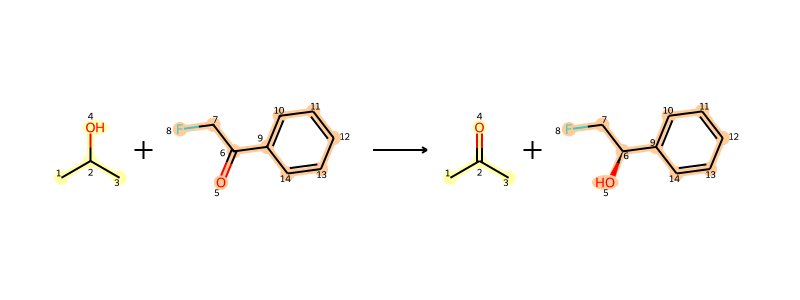

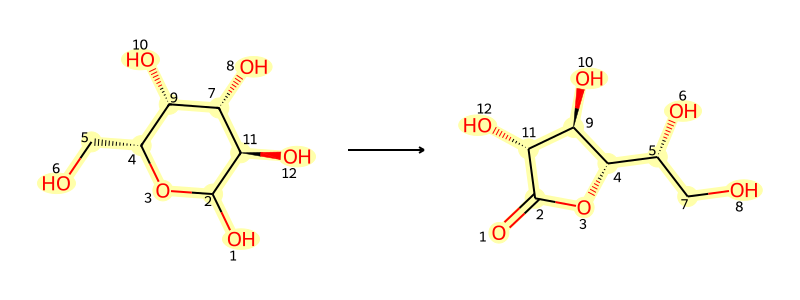

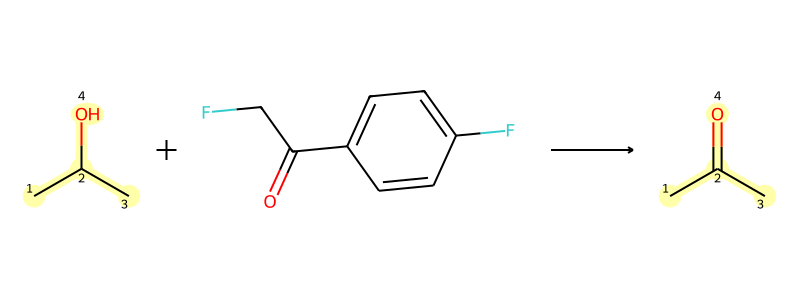

In [ ]:
def draw_chemical_reaction(smiles, highlightByReactant=False, font_scale=0.7):
    rxn = rdChemReactions.ReactionFromSmarts(smiles,useSmiles=True)
    trxn = rdChemReactions.ChemicalReaction(rxn)
    for m in trxn.GetReactants():
        moveAtomMapsToNotes(m)
    for m in trxn.GetProducts():
        moveAtomMapsToNotes(m)
    d2d = rdMolDraw2D.MolDraw2DSVG(800,300)
    d2d.drawOptions().annotationFontScale=font_scale
    d2d.DrawReaction(trxn,highlightByReactant=highlightByReactant)

    d2d.FinishDrawing()

    return d2d.GetDrawingText()

display(SVG(draw_chemical_reaction("[CH3:1][CH:2]([CH3:3])[OH:4].[O:5]=[C:6]([CH2:7][F:8])[c:9]1[cH:10][cH:11][cH:12][cH:13][cH:14]1>>[CH3:1][C:2]([CH3:3])=[O:4].[OH:5][C@@H:6]([CH2:7][F:8])[c:9]1[cH:10][cH:11][cH:12][cH:13][cH:14]1",  highlightByReactant=True)))
display(SVG(draw_chemical_reaction("[OH:1][CH:2]1[O:3][C@H:4]([CH2:5][OH:6])[C@H:9]([OH:10])[C@H:7]([OH:8])[C@H:11]1[OH:12]>>[O:1]=[C:2]1[O:3][C@@H:4]([C@H:5]([OH:6])[CH2:7][OH:8])[C@H:9]([OH:10])[C@H:11]1[OH:12]",  highlightByReactant=True)))
display(SVG(draw_chemical_reaction("[CH3:1][CH:2]([CH3:3])[OH:4].O=C(CF)c1ccc(F)cc1>>[CH3:1][C:2]([CH3:3])=[O:4]",  highlightByReactant=True)))


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2570873b-d089-4ed7-b836-6c2df496af15' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>